# Телекоммуникации

## Описание проекта и план работы

**Цель:**

Оператор связи хочет бороться с оттоком клиентов. Для этого 
его сотрудники начнут предлагать промокоды и специальные условия всем, 
кто планирует отказаться от услуг связи. Чтобы заранее находить таких 
пользователей, оператору нужна модель, которая будет предсказывать, 
разорвёт ли абонент договор.

**Описание услуг:**

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:

- Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
- Выделенная линия технической поддержки (TechSupport);
- Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

**Описание данных:**

Данные состоят из файлов, полученных из разных источников:

- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

**Задачи:**
- Загрузить и изучить данные
- Обработать данные 
- Построить модели и оценить их качество
- Выбрать лучшую модель и оценить её качество на тестовой выборке
- Составление отчёта

**Подробный план:**

1. Загрузить датасеты, вывести общую информацию о них;
2. Провести поиск пропусков и дубликатов;
3. Изучить, требуют ли данные дополнительной предобработки (изменить тип данных, переименовать столбцы, заполнить пропуски, удалить дубликаты);
4. Провести предобработку данных, добавить целевой признак;
5. Объединить исходные датафреймы в один, изучить распределение признаков;
6. Провести подготовку данных для обучения моделей (закодировать категориальные признаки, разбить данные на выборки);
7. Построить модели и подобрать для них гиперпараметры;
8. Обучить модели на тренировочной выборке и выбрать лучших из них на основе метрики AUC-ROC, значение метрики должно быть не меньше 0.85;
9. Провести оценку лучшей модели на тестовой выборке, найти значение метрики accuracy;
10. Проанализировать лучшую модель (важность признаков, матрица ошибок);
11. Сделать выводы по проделанной работе;
12. Указать основные этапы работы над проектом, какие проблемы возникли и что было предпринято для их решения;
13. Составить итоговый список признаков и способы их обработки, а также сводную таблицу исследованных моделей и показатели лучшей модели.

## Изучение данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, accuracy_score 

!pip install phik
import phik
from phik.report import plot_correlation_matrix
from time import time

import re
import warnings
warnings.filterwarnings('ignore')

In [2]:
contract = pd.read_csv('/datasets/contract_new.csv', parse_dates=['BeginDate', 'EndDate'])
internet = pd.read_csv('/datasets/internet_new.csv')
personal = pd.read_csv('/datasets/personal_new.csv')
phone = pd.read_csv('/datasets/phone_new.csv')

### Изучение датасета `contract`

In [3]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [4]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 440.3+ KB


In [5]:
contract.describe()

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


In [6]:
contract.duplicated().sum()

0

In [7]:
contract.isna().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

In [8]:
contract['EndDate'].sort_values().unique()

array(['2014-06-01', '2014-09-01', '2014-10-01', '2014-11-01',
       '2014-12-01', '2015-01-01', '2015-02-01', '2015-03-01',
       '2015-04-01', '2015-05-01', '2015-06-01', '2015-07-01',
       '2015-08-01', '2015-09-01', '2015-10-01', '2015-11-01',
       '2015-12-01', '2016-01-01', '2016-02-01', '2016-03-01',
       '2016-04-01', '2016-05-01', '2016-06-01', '2016-07-01',
       '2016-08-01', '2016-09-01', '2016-10-01', '2016-11-01',
       '2016-12-01', '2017-01-01', '2017-02-01', '2017-03-01',
       '2017-04-01', '2017-05-01', '2017-06-01', '2017-07-01',
       '2017-08-01', '2017-09-01', '2017-10-01', '2017-11-01',
       '2017-12-01', '2018-01-01', '2018-02-01', '2018-03-01',
       '2018-04-01', '2018-05-01', '2018-06-01', '2018-07-01',
       '2018-08-01', '2018-09-01', '2018-10-01', '2018-11-01',
       '2018-12-01', '2019-01-01', '2019-02-01', '2019-03-01',
       '2019-04-01', '2019-05-01', '2019-06-01', '2019-07-01',
       '2019-08-01', '2019-09-01', '2019-10-01', '2019-

**Тип столбца `TotalCharges`**

В данном столце хранится, сколько всего клиент потратил денег на услуги, но
тип данных - object, необходимо выяснить почему так происходит.

In [9]:
contract['TotalCharges'].sort_values().unique()

array([' ', '100.17', '100.19', ..., '998.89', '999.6', '999.9'],
      dtype=object)

При выводе уникальных значений найдены неявные пропуски, скорее всего пропуски
в столбце связаны с тем, что клиент заключил договор в день выгрузки данных, 
то есть 1 февраля 2020 года, и не тратил деньги на услуги.

Необходимо проверить данную гипотезу.

In [10]:
(contract[contract['TotalCharges'] == ' ']['BeginDate'] != '2020-02-01').sum()

0

Каждый раз, когда встречается пропуск в столбце `TotalCharges` значение в 
столбце `BeginDate` равно `2020-02-01`, что подтверждает теорию. Далее, при
обработке данных, необходимо будет заменить пропуски на значение `0`, что
позволит изменить тип данных.

**Результат изучения:**

1. Необходимо изменить тип данных в следующих колонках:`EndDate` на  `datetime`, `TotalCharges` на `float`;

2. Явных пропусков и дубликатов не было обнаружено, выбросов и подозрительных значений не найдено. В колонке `TotalCharges` обнаружены неявные пропуски, которые необходимо заменить на `0`;

3. На основе столбца `EndDate` необходимо выделить целевой признак, который будет отражать факт ухода клиента. Если значение в столбце `No`, то значение целевого признака равно `0` - клиент не ушёл, иначение значение равно `1` - клиент ушёл.

4. Названия столбцов необходимо привести в `snake_case`.

### Изучение датасета `personal`

In [11]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [12]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [13]:
personal.describe()

,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [14]:
personal.duplicated().sum()

0

In [15]:
personal.isna().sum()

customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

**Результат изучения:**

1. Явных пропусков и дубликатов не было обнаружено, выбросов и подозрительных значений не найдено;

2. Названия столбцов необходимо привести в `snake_case`.

### Изучение датасета `internet`

In [16]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [17]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [18]:
internet.describe()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,6771-XWBDM,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


In [19]:
internet.duplicated().sum()

0

In [20]:
internet.isna().sum()

customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

**Результат изучения:**

1. Явных пропусков и дубликатов не было обнаружено, выбросов и подозрительных значений не найдено;

2. В датасете представлены не все клиенты, так как не все пользуются интернет-услугами, что стоит учесть при обработке данных;

3. Названия столбцов необходимо привести в `snake_case`.

### Изучение датасета `phone`

In [21]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [22]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [23]:
phone.describe()

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,6771-XWBDM,No
freq,1,3390


In [24]:
phone.duplicated().sum()

0

In [25]:
phone.isna().sum()

customerID       0
MultipleLines    0
dtype: int64

**Результат изучения:**

1. Явных пропусков и дубликатов не было обнаружено, выбросов и подозрительных значений не найдено;

2. В датасете представлены не все клиенты, так как не все пользуются услугами телефонии, что стоит учесть при обработке данных;

3. Названия столбцов необходимо привести в `snake_case`.

## Предобработка данных

**Преобразование названий столбцов**

In [26]:
#Преобразование из camel case в snake case
def camel_to_snake(name):
    name = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', name).lower()

In [27]:
contract.columns = [camel_to_snake(i) for i in contract.columns]
personal.columns = [camel_to_snake(i) for i in personal.columns]
internet.columns = [camel_to_snake(i) for i in internet.columns]
phone.columns = [camel_to_snake(i) for i in phone.columns]
contract.info()
personal.info()
internet.info()
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 440.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-nul

**Создание целевого признака**

In [28]:
contract['former'] = (contract['end_date'] != 'No').astype(int)

In [29]:
contract.head(10)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,former
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,0
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,0
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,0
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,0
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96,0
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,0
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48,0
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68,0
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35,1


**Создание нового признака**

На основе двух столбцов: `begin_date` и `end_date` можно создать новый - период пользования услуг. Для этого необходимо заменить значение `No` в столбце `end_date` на дату выгрузки данных. После создания нового столбца необходимо удалить столбцы с датами.

In [30]:
contract['end_date'] = contract['end_date'].where(contract['end_date'] != 'No', '2020-02-01')

In [31]:
contract['end_date'] = pd.to_datetime(contract['end_date'])
contract['duration'] = (contract['end_date'] - contract['begin_date']).dt.days
contract = contract.drop(['begin_date', 'end_date'], axis=1)
contract.head()

,customer_id,type,paperless_billing,payment_method,monthly_charges,total_charges,former,duration
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,0,31
1,5575-GNVDE,One year,No,Mailed check,56.95,2071.84,0,1036
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,0,123
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.6,0,1371
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.5,0,153


**Заполнение неявных пропусков с столбце `total_charges` и преобразование типа данных** 

В предобработке было выяснено, что пропуски в столбце `total_charges` связаны с тем, что некоторые пользователи - новые и не успели ничего заплатить, поэтому пропуски в данном столбце необходимо заменить на значение `0`. 

После замены неявных пропусков тип данных можно заменить на `float`.

In [32]:
contract['total_charges'] = contract['total_charges'].where(contract['total_charges'] != ' ', 0)
contract['total_charges'] = contract['total_charges'].astype(float)
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   type               7043 non-null   object 
 2   paperless_billing  7043 non-null   object 
 3   payment_method     7043 non-null   object 
 4   monthly_charges    7043 non-null   float64
 5   total_charges      7043 non-null   float64
 6   former             7043 non-null   int64  
 7   duration           7043 non-null   int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 440.3+ KB


### Объединение и исследование данных

In [33]:
data = (contract.merge(personal, on =['customer_id'], how='left')
                .merge(internet, on =['customer_id'], how='left')
                .merge(phone, on =['customer_id'], how='left')
)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   type               7043 non-null   object 
 2   paperless_billing  7043 non-null   object 
 3   payment_method     7043 non-null   object 
 4   monthly_charges    7043 non-null   float64
 5   total_charges      7043 non-null   float64
 6   former             7043 non-null   int64  
 7   duration           7043 non-null   int64  
 8   gender             7043 non-null   object 
 9   senior_citizen     7043 non-null   int64  
 10  partner            7043 non-null   object 
 11  dependents         7043 non-null   object 
 12  internet_service   5517 non-null   object 
 13  online_security    5517 non-null   object 
 14  online_backup      5517 non-null   object 
 15  device_protection  5517 non-null   object 
 16  tech_support       5517 

In [34]:
data.head()

,customer_id,type,paperless_billing,payment_method,monthly_charges,total_charges,former,duration,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,0,31,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,One year,No,Mailed check,56.95,2071.84,0,1036,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,0,123,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.60,0,1371,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.50,0,153,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


**Заполнение пропусков**

При объединении таблиц появились пропуски в столбцах, связанных с интернет услугами и услугами телефонии. Они появились из-за того, что не все клиенты пользуются данными услугами. Пропуски в столбцах означают, что пользователь не пользуется услугой, связанной с этим столбцов, остальные пропуски были удалены на предыдущем этапе. Данные пропуски необходимо обработать так, чтобы отличать пользователей, которые не пользуются пакетом целиком и пользователей, которые не пользуются конкретной услугой из пакета, для этого появившиеся пропуски заполним новым значением `NoService`. 

In [35]:
data.isna().sum()

customer_id             0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
former                  0
duration                0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
multiple_lines        682
dtype: int64

In [36]:
data = data.fillna('NoService')
data.sample(10)

,customer_id,type,paperless_billing,payment_method,monthly_charges,total_charges,former,duration,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
3492,0975-VOOVL,Month-to-month,No,Mailed check,29.20,87.60,0,92,Female,0,No,No,DSL,No,Yes,No,No,No,No,NoService
3256,7711-YIJWC,One year,No,Bank transfer (automatic),84.90,5437.85,0,1857,Male,0,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,Yes,No
5647,7502-BNYGS,Month-to-month,Yes,Credit card (automatic),69.10,3178.60,0,1401,Female,0,Yes,No,DSL,No,Yes,No,No,Yes,Yes,No
1348,1184-PJVDB,Month-to-month,Yes,Electronic check,79.95,1039.35,0,396,Male,0,Yes,No,Fiber optic,No,No,No,No,Yes,No,No
2824,8857-CUPFQ,Two year,No,Mailed check,19.25,1309.77,0,1918,Male,0,Yes,No,NoService,NoService,NoService,NoService,NoService,NoService,NoService,No
2708,8510-AWCXC,Month-to-month,Yes,Electronic check,100.80,1512.00,0,457,Female,1,No,No,Fiber optic,Yes,No,No,No,Yes,Yes,Yes
3358,5447-VYTKW,Month-to-month,No,Mailed check,53.45,1443.15,0,822,Male,0,No,No,DSL,Yes,No,No,Yes,No,No,No
3865,5701-SVCWR,Month-to-month,No,Mailed check,24.00,25.92,0,31,Female,0,No,Yes,NoService,NoService,NoService,NoService,NoService,NoService,NoService,Yes
3650,5699-BNCAS,Two year,Yes,Mailed check,24.65,1750.15,0,2163,Male,1,No,No,NoService,NoService,NoService,NoService,NoService,NoService,NoService,Yes
259,5046-NUHWD,Month-to-month,Yes,Electronic check,45.00,1318.05,0,883,Female,1,Yes,No,DSL,Yes,No,Yes,No,No,Yes,NoService


Если в строке встречается значение `NoService`, то значения всех столбцов, связанных с данным пакетом услуг тоже равны значению `NoService`, это означает, что заполнение прошло корректно.

Значение в столбце `customer_id` уникальное для каждого пользователя, поэтому при построении моделей его можно не учитывать.

In [37]:
data = data.drop('customer_id', axis=1)

**Распределение признаков**

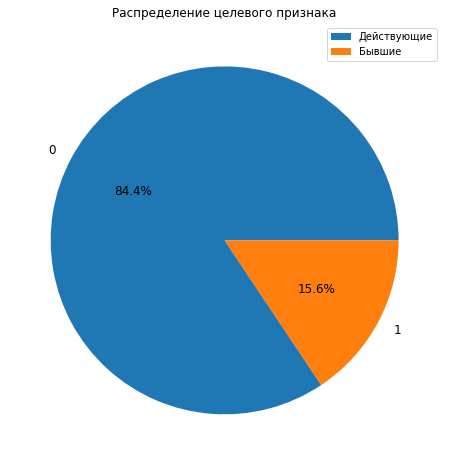

In [38]:
data.groupby('former').size().plot(kind='pie', 
                                   autopct='%1.1f%%', 
                                   figsize=(8, 8),
                                   fontsize=12,
                                   ylabel='')
plt.title('Распределение целевого признака')
plt.legend(['Действующие', 'Бывшие']);

Заметно, что большинство пользователей остаются клиентами компании.

Изучим распределение ежемесячного платежа всех клиентов и отдельно для действующих и бывших клиентов.

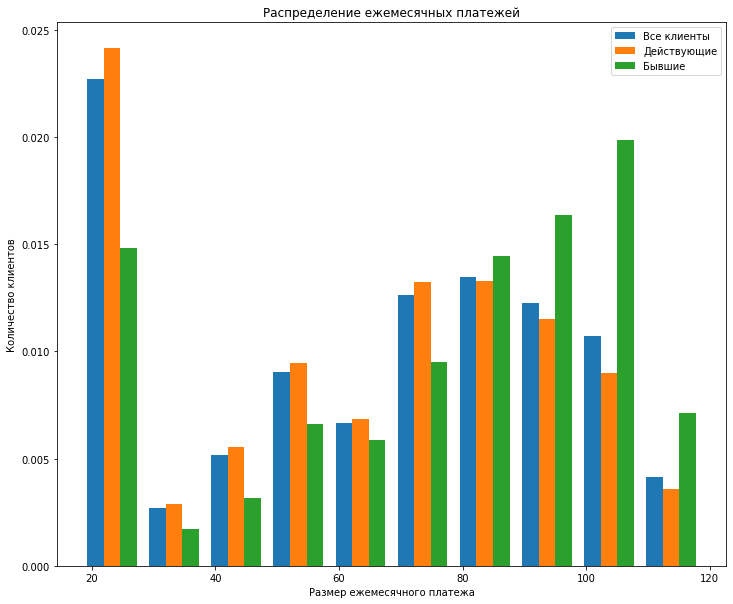

In [39]:
plt.figure(figsize=(12, 10))
charges_data = [data['monthly_charges'],
                data[data['former'] == 0]['monthly_charges'],
                data[data['former'] == 1]['monthly_charges']]
plt.hist(charges_data, density=True)
plt.legend(['Все клиенты', 'Действующие', 'Бывшие'])
plt.title('Распределение ежемесячных платежей')
plt.ylabel('Количество клиентов')
plt.xlabel('Размер ежемесячного платежа');

Большинство клиентов платят по договору около 20. Распределение бывших клиентов отличается - среди них самый популярный ежемесячный платеж около 100.

Изучим распределение продолжительности пользования услугами

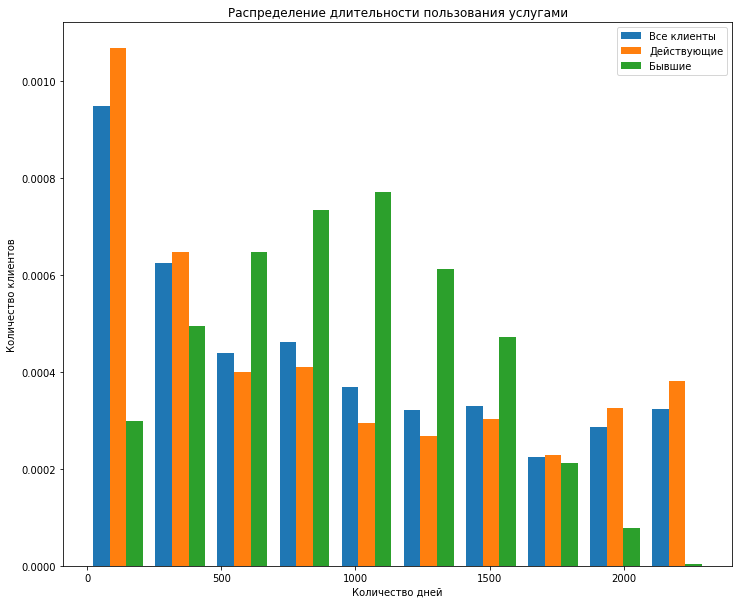

In [40]:
plt.figure(figsize=(12, 10))
duration_data = [data['duration'],
                data[data['former'] == 0]['duration'],
                data[data['former'] == 1]['duration']]
plt.hist(duration_data, density=True)
plt.legend(['Все клиенты', 'Действующие', 'Бывшие'])
plt.title('Распределение длительности пользования услугами')
plt.ylabel('Количество клиентов')
plt.xlabel('Количество дней');

По графику видно, что большинство пользователей новые и пользуются услугами меньше года, среди бывших клиентов чаще всего услугами пользовались около 1000 дней. 

In [41]:
yes_no_columns = ['paperless_billing', 'partner', 'dependents', 'senior_citizen',
                  'multiple_lines', 'online_security', 
                  'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']

In [42]:
customer_data = ((data[yes_no_columns] == 'Yes') | (data[yes_no_columns] == 1)).sum()
customer_data['all_customers'] = data.shape[0]

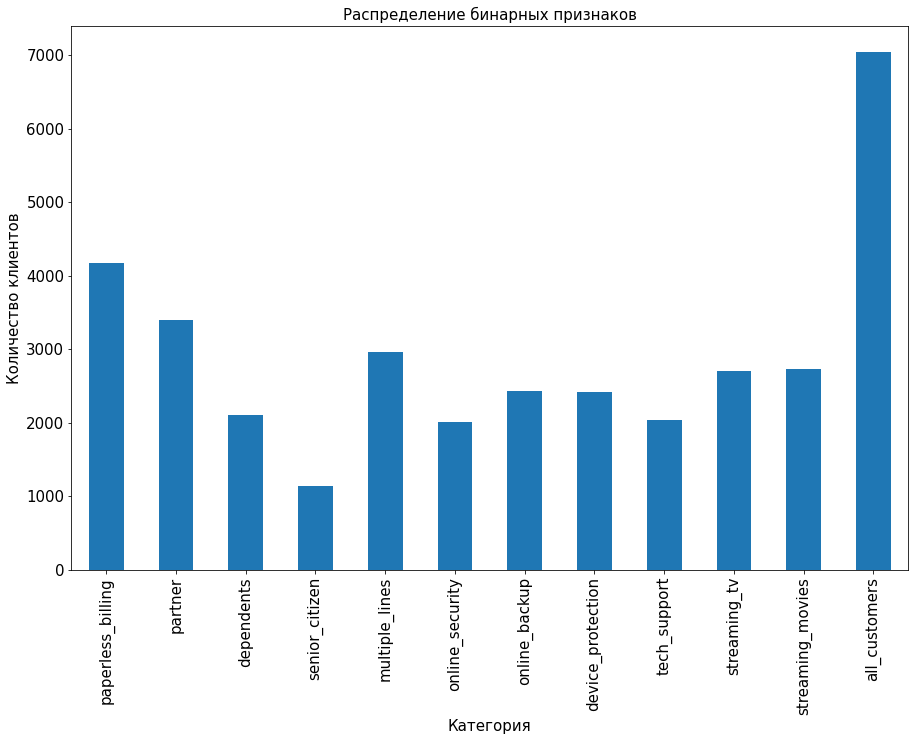

In [43]:
plt.figure(figsize=(15, 10))
plt.title('Распределение бинарных признаков', fontsize=15)
plt.ylabel('Количество клиентов', fontsize=15)
plt.xlabel('Категория', fontsize=15)
customer_data.plot(kind='bar', fontsize=15);

**Результат:**

При построении распределения бинарных признаков можно заметить, что услугами телефонии пользуются чуть больше, чем услугами интернета. Менее половины всех клиентов, которые пользуются услугами телефонии или интернет услугами, пользуются дополнительными услугами, такими как: возможность ведения параллельных линий во время звонка или стриминговыми услугами.

Большинство клиентов используют электронный платежный документ, менее половины имеют супруга(у), малая часть клиентов имеют иждивенцев и пенсионный статус по возрасту. 

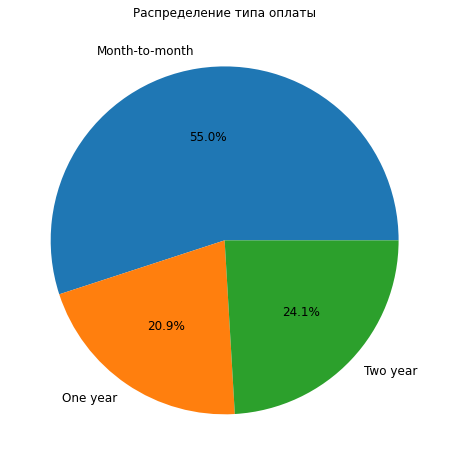

In [44]:
data.groupby('type').size().plot(kind='pie', 
                                 autopct='%1.1f%%', 
                                 figsize=(8, 8),
                                 fontsize=12)
plt.ylabel('')
plt.title('Распределение типа оплаты');

**Результат:**

Большинство клиентов платят ежемесячно (55%), распределение клиентов, которые платят ежегодно или раз в два года примерно равно с небольшим перевесом в сторону тех, кто платит раз в два года.

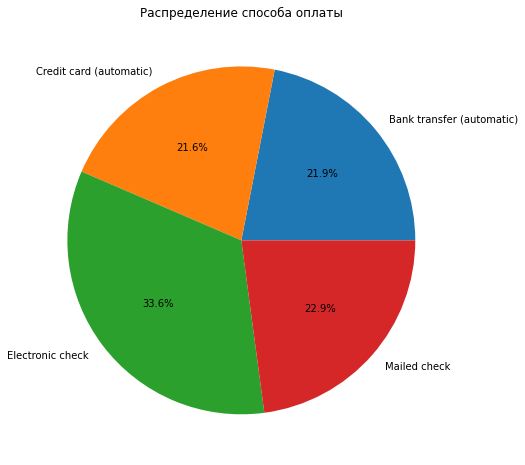

In [45]:
data.groupby('payment_method').size().plot(kind='pie', 
                                   autopct='%1.1f%%', 
                                   figsize=(8, 8))
plt.ylabel('')
plt.title('Распределение способа оплаты');

**Результат:**

Самый частый способ оплаты - электронный чек, остальные способы встречаются примерно с одинаковой частотой.

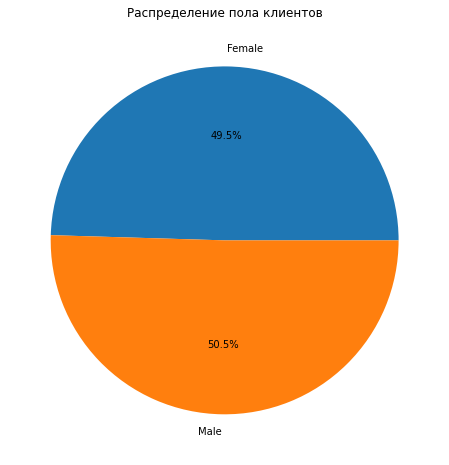

In [46]:
data.groupby('gender').size().plot(kind='pie', 
                                   autopct='%1.1f%%', 
                                   figsize=(8, 8))
plt.ylabel('')
plt.title('Распределение пола клиентов');

**Результат:**

Среди клиентов чуть чаще (всего на 1%) встречаются мужчины.

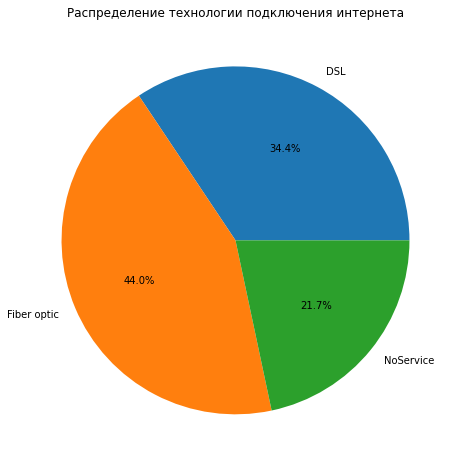

In [47]:
data.groupby('internet_service').size().plot(kind='pie', 
                                   autopct='%1.1f%%', 
                                   figsize=(8, 8))
plt.ylabel('')
plt.title('Распределение технологии подключения интернета');

**Результат:**

Чаще всего используется оптоволоконное подключение, реже - DSL-соединение. 21.7% пользователей не пользуются интернет услугами.

Изучим корреляцию между признаками.

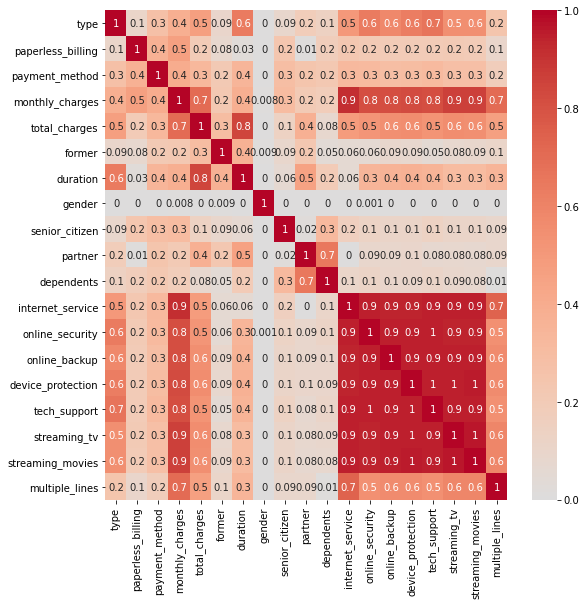

In [48]:
heat_data = data.phik_matrix(interval_cols=['monthly_charges', 'total_charges', 'duration'])
plt.figure(figsize=(9, 9))
sns.heatmap(heat_data,
            annot=True, 
            fmt='.1g',
            cmap='coolwarm',
            center=0);

**Результаты:**

1. Сильная зависимость между ежемесячными и общими платежами и всеми услугами (интернет, стриминговые услуги и телефония), такая зависимость очевидна так как при подключении услуг ежемесячный платеж, а также сумма всех платежей, увеличиваются.

2. Сильная зависимость между длительностью пользования и суммой платежей, чем дольше клиент пользуется услугами, тем больше денег он суммарно заплатит.

3. Целевой признак имеет малую зависимость со следующими столбцами: `type`, `paperless_billing`, `gender`, `senior_citizen`, `dependents` и `internet_services`. С другими столбцами есть небольшая зависимость - до 0,4.

**Разбиение данных на выборки**

In [49]:
target = data['former']
features = data.drop('former', axis=1)

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=161023, stratify=target)

print('Размеры и размерности выборок:', features_train.shape, features_test.shape)

Размеры и размерности выборок: (5282, 18) (1761, 18)


**Кодирование и масштабирование данных**

In [50]:
data.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,former,duration,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,Month-to-month,Yes,Electronic check,29.85,31.04,0,31,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NoService
1,One year,No,Mailed check,56.95,2071.84,0,1036,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,Month-to-month,Yes,Mailed check,53.85,226.17,0,123,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,One year,No,Bank transfer (automatic),42.30,1960.60,0,1371,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NoService
4,Month-to-month,Yes,Electronic check,70.70,353.50,0,153,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [51]:
categorical_columns = ['type', 'payment_method', 'gender', 'internet_service', 
                       'paperless_billing', 'partner', 'dependents', 'online_security', 
                       'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 
                       'streaming_movies', 'multiple_lines']
numerical_columns = ['monthly_charges', 'total_charges', 'duration']

In [52]:
pd.options.mode.chained_assignment = None
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

In [53]:
features_train[categorical_columns] = encoder.fit_transform(features_train[categorical_columns])
features_test[categorical_columns] = encoder.transform(features_test[categorical_columns])

display(features_train.head())
display(features_test.head())

,type,paperless_billing,payment_method,monthly_charges,total_charges,duration,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
4509,0.0,0.0,2.0,84.30,168.60,62,0.0,0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0
3585,1.0,0.0,3.0,90.15,3187.70,1036,1.0,1,1.0,0.0,1.0,2.0,0.0,0.0,2.0,2.0,0.0,0.0
6325,0.0,0.0,2.0,91.85,1745.15,580,0.0,0,1.0,1.0,1.0,2.0,0.0,0.0,2.0,2.0,0.0,0.0
6490,1.0,0.0,3.0,19.40,504.40,792,1.0,0,0.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
5712,0.0,1.0,0.0,20.30,466.90,702,0.0,0,0.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


,type,paperless_billing,payment_method,monthly_charges,total_charges,duration,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
5723,0.0,0.0,0.0,80.65,4724.48,1767,1.0,0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0
5869,1.0,0.0,2.0,94.40,4527.42,1340,0.0,0,1.0,1.0,1.0,0.0,2.0,2.0,0.0,0.0,2.0,2.0
6973,1.0,1.0,2.0,94.00,3188.48,973,0.0,1,1.0,0.0,1.0,0.0,2.0,2.0,2.0,2.0,0.0,0.0
3782,0.0,1.0,2.0,84.05,1008.60,365,0.0,0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0
3096,2.0,1.0,1.0,61.40,4402.99,2163,0.0,0,1.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,1.0


In [54]:
scaler = StandardScaler()

features_train[numerical_columns] = scaler.fit_transform(features_train[numerical_columns])
features_test[numerical_columns] = scaler.transform(features_test[numerical_columns])

display(features_train.head())
display(features_test.head())

,type,paperless_billing,payment_method,monthly_charges,total_charges,duration,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
4509,0.0,0.0,2.0,0.646685,-0.921703,-1.226347,0.0,0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0
3585,1.0,0.0,3.0,0.841338,0.507067,0.201782,1.0,1,1.0,0.0,1.0,2.0,0.0,0.0,2.0,2.0,0.0,0.0
6325,0.0,0.0,2.0,0.897904,-0.175610,-0.466829,0.0,0,1.0,1.0,1.0,2.0,0.0,0.0,2.0,2.0,0.0,0.0
6490,1.0,0.0,3.0,-1.512797,-0.762787,-0.155984,1.0,0,0.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
5712,0.0,1.0,0.0,-1.482851,-0.780534,-0.287946,0.0,0,0.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


,type,paperless_billing,payment_method,monthly_charges,total_charges,duration,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
5723,0.0,0.0,0.0,0.525235,1.234339,1.273612,1.0,0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0
5869,1.0,0.0,2.0,0.982752,1.141081,0.647522,0.0,0,1.0,1.0,1.0,0.0,2.0,2.0,0.0,0.0,2.0,2.0
6973,1.0,1.0,2.0,0.969443,0.507436,0.109408,0.0,1,1.0,0.0,1.0,0.0,2.0,2.0,2.0,2.0,0.0,0.0
3782,0.0,1.0,2.0,0.638367,-0.524178,-0.782073,0.0,0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0
3096,2.0,1.0,1.0,-0.115289,1.082196,1.854247,0.0,0,1.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,1.0


### Вывод по предобработке данных

1. Названия столбцов приведены к snake case.

2. Заполнены пропуски в данных.

3. Удалены нерелевантные столбцы.

4. Изучено распределение признаков, целевой признак несбалансирован, что необходимо учесть.

5. Изучена корреляция между признаками.

## Обучение моделей

**Дерево решений**

In [55]:
%%time

params = {'max_depth': [None] + [i for i in range(1, 8)],
          'min_samples_leaf' : range (1,6),
          'max_features' : range(1,7)}

model = DecisionTreeClassifier(random_state=161023)

start = time()

grid = GridSearchCV(model, cv=5, scoring='roc_auc', param_grid=params)
grid.fit(features_train, target_train)

end = time()

dt_auc_roc = grid.best_score_
dt_time = (end-start) / 60
print('Лучший ROC-AUC на кросс-валидации:', grid.best_score_)
print('Лучшие параметры модели:', grid.best_params_)

Лучший ROC-AUC на кросс-валидации: 0.7742655480013145
Лучшие параметры модели: {'max_depth': 6, 'max_features': 6, 'min_samples_leaf': 4}
CPU times: user 8.9 s, sys: 26 ms, total: 8.92 s
Wall time: 8.94 s


**Случайный лес**

In [56]:
%%time

params = {'max_depth': [None] + [i for i in range(2, 7)], 
          'n_estimators': [50, 100, 500],
          'criterion': ['gini', 'entropy']}

model = RandomForestClassifier(random_state=161023)

start = time()

grid = GridSearchCV(model, cv=5, scoring='roc_auc', param_grid=params, verbose=1)
grid.fit(features_train, target_train)

end = time()

rf_auc_roc = grid.best_score_
rf_time = (end-start) / 60
print('Лучший ROC-AUC на кросс-валидации:', grid.best_score_)
print('Лучшие параметры модели:', grid.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Лучший ROC-AUC на кросс-валидации: 0.8253878352610065
Лучшие параметры модели: {'criterion': 'gini', 'max_depth': 6, 'n_estimators': 500}
CPU times: user 1min 58s, sys: 677 ms, total: 1min 59s
Wall time: 1min 59s


**CatBoostClassifier**

In [57]:
%%time

params = {'max_depth': [None, 1, 2, 3], 
          'n_estimators': [500, 1000, 2000],
          'learning_rate': [0.1, 0.5, 0.8]}

model = CatBoostClassifier(random_state=161023, eval_metric='AUC', loss_function='Logloss', silent=True)

start = time()

grid = GridSearchCV(model, cv=5, scoring='roc_auc', param_grid=params)
grid.fit(features_train, target_train)

end = time()

cb_auc_roc = grid.best_score_
cb_time = (end-start) / 60
print('Лучший ROC-AUC на тренировочной выборке:', grid.best_score_)
print('Лучшие параметры модели:', grid.best_params_)

Лучший ROC-AUC на тренировочной выборке: 0.9224794291005706
Лучшие параметры модели: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 2000}
CPU times: user 4min 2s, sys: 18.5 s, total: 4min 21s
Wall time: 7min 10s


In [58]:
pd.DataFrame({'Модель': ['DecisionTreeClassifier','RandomForestClassifier', 'CatBoostClassifier'],
              'Результат ROC-AUC':[dt_auc_roc, rf_auc_roc, cb_auc_roc],
              'Время поиска лучших параметров (min)':[f'{dt_time:0.2}', f'{rf_time:0.1f}', f'{cb_time:0.1f}']})

,Модель,Результат ROC-AUC,Время поиска лучших параметров (min)
0,DecisionTreeClassifier,0.774266,0.15
1,RandomForestClassifier,0.825388,2.0
2,CatBoostClassifier,0.922479,7.2


**Лучшая модель**

Модель с лучшим показателем на тестовой выборке - CatBoostClassifier, ее необходимо проверить на тестовой выборке.

### Тестирование модели

In [59]:
model = grid.best_estimator_
model.fit(features_train, target_train)

In [60]:
predictions = model.predict(features_test)
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

auc_roc = roc_auc_score(target_test, probabilities_one_test)
accuracy = accuracy_score(target_test, predictions)
print(f'AUC-ROC модели Catboost на тестовой выборке: {auc_roc:0.3}')
print(f'Значение Accuracy на тестовой выборке: {accuracy:0.3}')

AUC-ROC модели Catboost на тестовой выборке: 0.936
Значение Accuracy на тестовой выборке: 0.944


**Результат:**

Лучшая модель дала следующие результаты на тестовой выборке: AUC-ROC = 0.939, Accuracy = 0.945. Метрика Accuracy отражает общую точность модели, то есть в данном случае означает, что наша модель на тестовой выборке сделала 94,5% правильных предсказаний. 

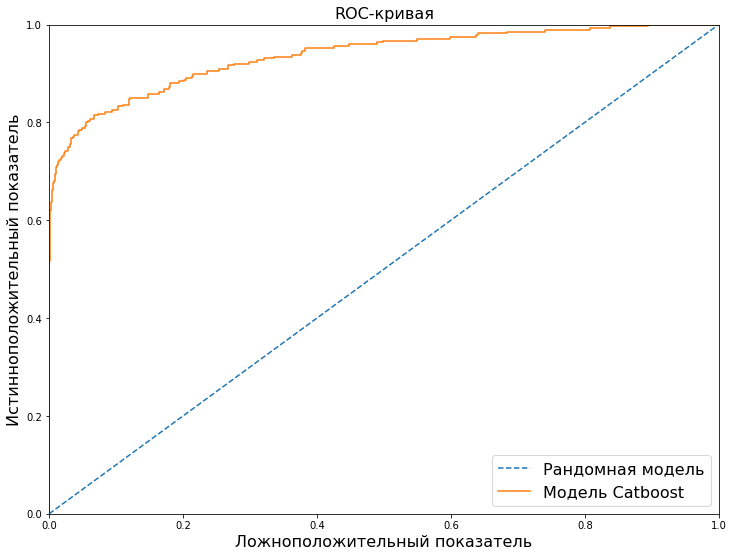

In [61]:
plt.figure(figsize=[12,9])

plt.plot([0, 1], [0, 1], linestyle='--', label='Рандомная модель')
plt.plot(fpr, tpr, label='Модель Catboost')

plt.xlim([0,1])
plt.ylim([0,1])

plt.title('ROC-кривая', fontsize=16)
plt.xlabel('Ложноположительный показатель', fontsize=16)
plt.ylabel('Истинноположительный показатель', fontsize=16)

plt.legend(loc='lower right', fontsize=16)

plt.show()

Рассмотрим важность признаков

In [62]:
features_importance = (
    pd.DataFrame(data = {'Признаки': features_train.columns, 
                         'Доля в процентах': np.round(model.feature_importances_, decimals=1)})
)
features_importance.sort_values('Доля в процентах', ascending=False).reset_index(drop=True)

,Признаки,Доля в процентах
0,duration,68.9
1,total_charges,8.9
2,monthly_charges,7.7
3,type,4.2
4,multiple_lines,2.1
5,partner,1.9
6,payment_method,1.5
7,online_backup,1.0
8,internet_service,0.7
9,device_protection,0.6


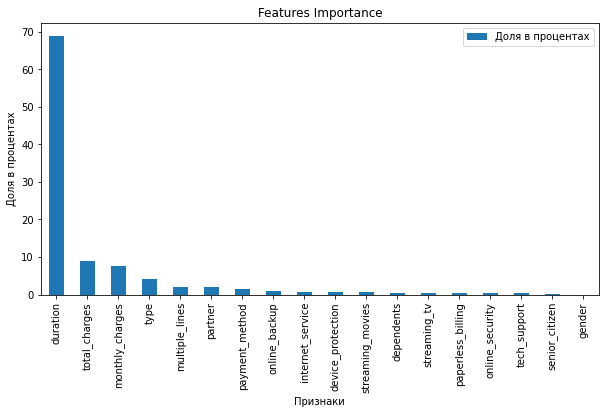

In [63]:
features_importance.index=features_importance['Признаки']
(features_importance.sort_values(by='Доля в процентах', ascending=False)
                    .plot(kind='bar',
                          title='Features Importance',
                          ylabel='Доля в процентах',
                          xlabel='Признаки',
                          figsize=(10, 5)));

Наиболее важный параметр при предсказании - длительность пользования услугами, чуть менее важные параметры - месячный и суммарный платежи.

Построим матрицу ошибок.

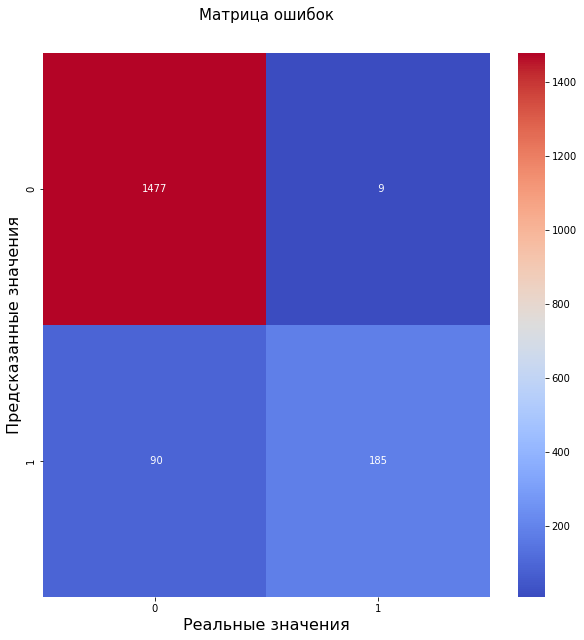

In [64]:
plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix(target_test, predictions), annot=True, fmt='3.0f', cmap= 'coolwarm')
plt.title('Матрица ошибок', y=1.05, size=15)
plt.xlabel('Реальные значения', fontsize=16)
plt.ylabel('Предсказанные значения', fontsize=16)
plt.show()

**Результат:**

Матрица ошибок отражает 4 метрики:
1. True Positive (истинно-положительно), правая нижняя метрика на графике - модель предсказала, что клиент разорвет контракт и действительно, так и произошло. 
2. True Negative (истинно-отрицательно), левая верхняя метрика на графике - модель предсказала, что клиент не разорвет контракт, что соответствует действительности
3. False Positive (ложно-положительно), левая нижняя метрика на графике - модель предсказала, что клиент разорвет контракт, но этого не случилось.
4. False Negative (ложно-отрицательно), правая верхняя метрика на графике - модель предсказала, что клиент останется, но на самом деле, он разорвал контракт.

Чаще всего встречается метрика истинно-отрицательная, что логично, ведь большая часть клиентов не разрывает контракт, модель в большинстве случаев правильно предсказывает, что клиент не собирается разорвать контракт.

Значительно реже встречается истинно-положительная метрика, это обосновывается тем, что малая часть клиент разрывает контракт, такие случаи модель тоже хорошо определяет и чаще всего определяет правильно, что клиент разорвет контракт.

Значения ложно-положительной и ложно-отрицательной метрик встречается совсем редко, это означает, что модель с предсказаниями справляется. К примеру из всех случаев, когда клиент разрывал контракт, модель правильно предсказывала 185 раз и неправильно всего 9 раз. А из тех случаев, когда клиент не разрывал контракт модель правильно предсказывала 1477 раз и неправильно всего 90 раз. 

### Вывод:

1. Данные разделены на тренировочную и тестовую, закодированы и масштабированы.

2. Для обучения были выбраны следующие модели: решающее дерево, случайный лес и сatboost;

3. С помощью GridSearchCV были найдены лучшие гиперпараметры моделей на тренировочной выборке,  лучший показатель AUC-ROC у модели Catboost равен 0.92;

4. Модель Catboost CatBoostClassifier с лучшими параметрами на тестовой выборке показала AUC-ROC = 0.936, Accuracy = 0.944;

5. Наиболее важными признаками для модели оказались: продолжительность пользования услугами, месячный и суммарный платежи.

6. На матрице ошибок видно, что модель достигла хороших результатов.

## Отчет

### Ключевые шаги работы над проектом

В начале проекта были поставлены следующие задачи:

- Загрузить и изучить данные
- Обработать данные 
- Построить модели и оценить их качество
- Выбрать лучшую модель и оценить её качество на тестовой выборке

### Анализ соответствия фактической работы запланированным шагам

В ходе проекта все задачи были выполнены:

**Загрузить и изучить данные:**

- [x] Загрузить данные 
- [x] Провести поиск пропусков и дубликатов
- [x] Изучить, требуют ли данные дополнительной предобработки(изменить тип данных, переименовать столбцы, заполнить пропуски, удалить дубликаты)

**Обработать данные:**

- [x] Добавить целевой признак
- [x] Объединить исходные датафреймы в один, изучить распределение признаков
- [x] Провести подготовку данных для обучения моделей (закодировать категориальные признаки, разбить данные на выборки)

**Построить модели и оценить их качество:**

- [x] Построить модели и подобрать для них лучшие гиперпараметры
- [x] Обучить модели на тренировочной выборке посчитать для них метрику AUC-ROC

**Выбрать лучшую модель и оценить ее качество на тестовой выборке:**

- [x] Выбрать лучшую модель на основе метрики AUC-ROC 
- [x] Провести оценку лучшей модели на тестовой выборке, найти значение метрики Accuracy
- [x] Проанализировать лучшую модель (важность признаков, матрица ошибок)

### Рефлексия над сложностями и описание путей их решения

В ходе выполнения проекта столкнулся со следующей проблемой:

- При объединении таблиц появились пропуски, которые непонятно было, чем заполнить. Решение - так как данные пропуски появились из-за того, что некоторые клиенты не пользовались теми или иными пакетами услуг, то данные пропуски необходимо было заполнить уникальным значением.
### Краткое описание предобработки данных

В ходе предобработки данных выявлены следующие проблемы и их решения:

* Некорректное название столбцов - названия столбцов преобразованы в snake case;
* Отсутствие целевого признака - создание целевого признака на основе значений столбца `EndDate` в датафрейме `contract`;
* Создан новый признак - длительность контракта;
* Найдены неявные пропуски в столбце `total_charges` в датафрейме `contract` - было принято решение заменить пропуски значением `0`, так как выявлено, что данные пропуски связаны с новыми клиентами, которые не успели поттратить деньги;
* В некоторых столбцах некорректные типы данных - типы данных были преобразованы;
* Данные разбросаны по нескольким таблицами - объединены по значению `customer_id`;
* При объединении таблиц появлись пропуски - выявлено, что данные пропуски связаны с тем, что некоторые клиенты не приобрели пакет услуг телефонии или интернет услуги, и принято решение заполнить данные пропуски уникальным значением `NoService`.

### Итоговый список признаков для обучения модели, способы их обработки

Для обучения модели были использованы следующие признаки:

1. type	- тип оплаты (ежемесячный/годовой/раз в два года)
2. paperless_billing - наличие электронного платежного документа
3. payment_method - способ оплаты
4. monthly_charges - ежемесячные траты на услуги по договору
5. total_charges - суммарные траты на услуги
6. duration - длительность контракта
7. gender - пол клиента
8. senior_citizen - наличие пенсионного статуса
9. partner - наличие супруга(и)
10. dependents - наличие иждивенцев
11. internet_service - технология подключения интернета
12. online_security
13. online_backup
14. device_protection
15. tech_support
16. streaming_tv
17. streaming_movies
18. multiple_lines - наличие возможности ведения параллельных линий во время звонка 

* Для кодирования признаков использовал `OrdinalEncoder`;
* Для масштабирования признаков использовал `StandartScaler`;
* Использовалось значение RANDOM_STATE = 161023;
* Данные были разделены на выборки с помощью `train_test_split` в соотношении 75% - обучающая выборка, 25% - тестовая выборка.
### Сводная таблица исследованных моделей и их метрика на кросс-валидации

Модели были обучены на тренировочной выборке и оценены на кросс-валидации, получены следующие значения
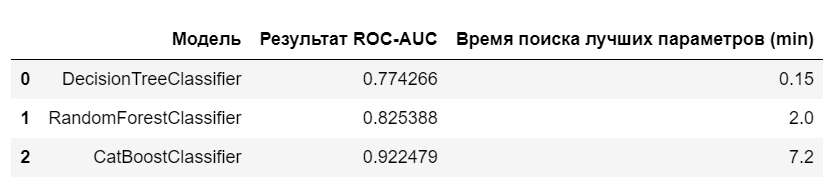
### Лучшая модель
Лучше всего себя показала модель CatBoostClassifier со следующими параметрами:

* learning_rate: 0.1
* max_depth: 2
* n_estimators: 2000

Данная модель на кросс-валидации показала метрику ROC-AUC равную 0.92
### Итоговая метрика на test (AUC-ROC и Accuracy)

Лучшая модель проверена на тестовой выборке, получены следующие метрики:

* AUC-ROC = 0.939

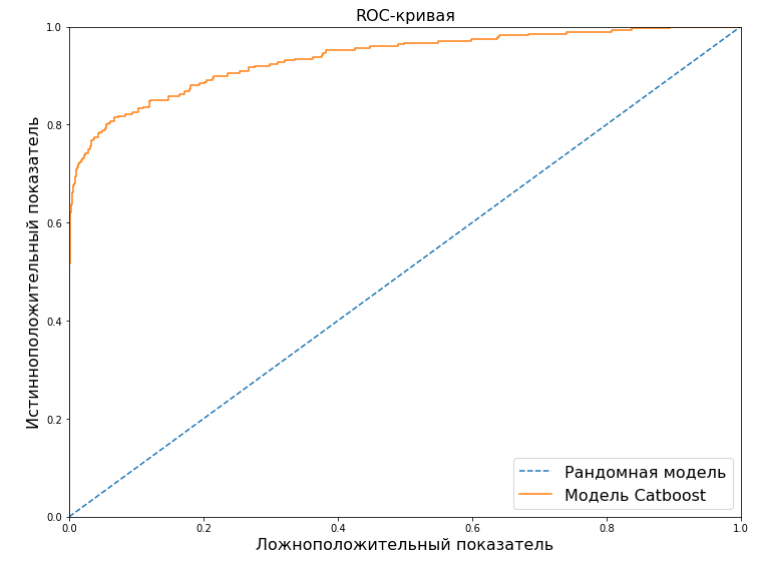

* Accuracy = 0.945. Метрика Accuracy отражает общую точность модели, то есть в данном случае означает, что наша модель на тестовой выборке сделала 94,5% правильных предсказаний. 

Данные результаты удовлетворяют нас, так как цель исследования была найти модель с метрикой ROC-AUC не меньше 0,85.
### Матрица ошибок

Построена матрица ошибок на тестовой выборке для лучшей модели, получен следующий результат:

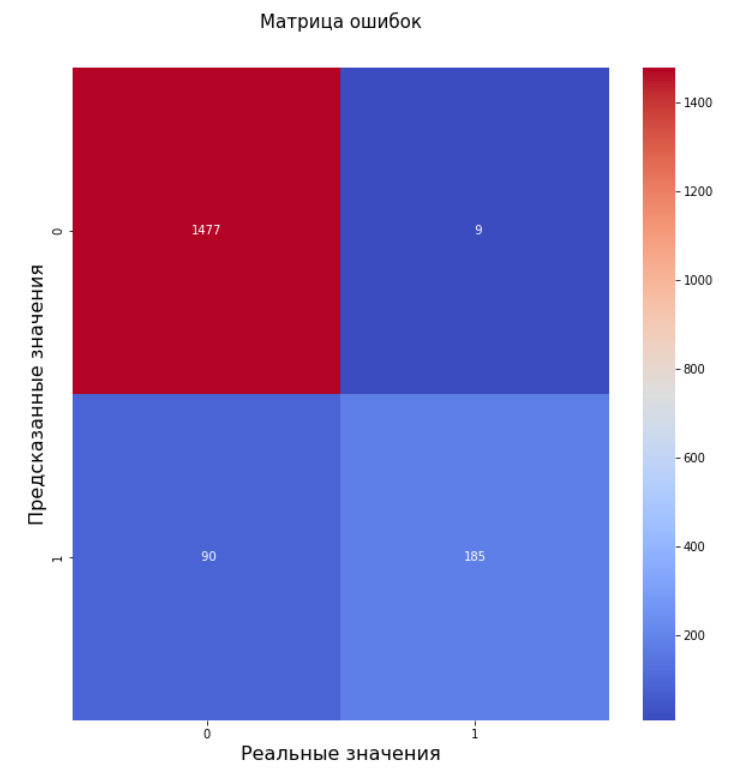

Матрица ошибок отражает 4 метрики:

True Positive (истинно-положительно), правая нижняя метрика на графике - модель предсказала, что клиент разорвет контракт и действительно, так и произошло.
True Negative (истинно-отрицательно), левая верхняя метрика на графике - модель предсказала, что клиент не разорвет контракт, что соответствует действительности
False Positive (ложно-положительно), левая нижняя метрика на графике - модель предсказала, что клиент разорвет контракт, но этого не случилось.
False Negative (ложно-отрицательно), правая верхняя метрика на графике - модель предсказала, что клиент останется, но на самом деле, он разорвал контракт.
Чаще всего встречается метрика истинно-отрицательная, что логично, ведь большая часть клиентов не разрывает контракт, модель в большинстве случаев правильно предсказывает, что клиент не собирается разорвать контракт.

Значительно реже встречается истинно-положительная метрика, это обосновывается тем, что малая часть клиент разрывает контракт, такие случаи модель тоже хорошо определяет и чаще всего определяет правильно, что клиент разорвет контракт.

Значения ложно-положительной и ложно-отрицательной метрик встречается совсем редко, это означает, что модель с предсказаниями справляется. К примеру из всех случаев, когда клиент разрывал контракт, модель правильно предсказывала 185 раз и неправильно всего 9 раз. А из тех случаев, когда клиент не разрывал контракт модель правильно предсказывала 1477 раз и неправильно всего 90 раз.
### Важность признаков

Изучена важность признаков, получен следующий результат:

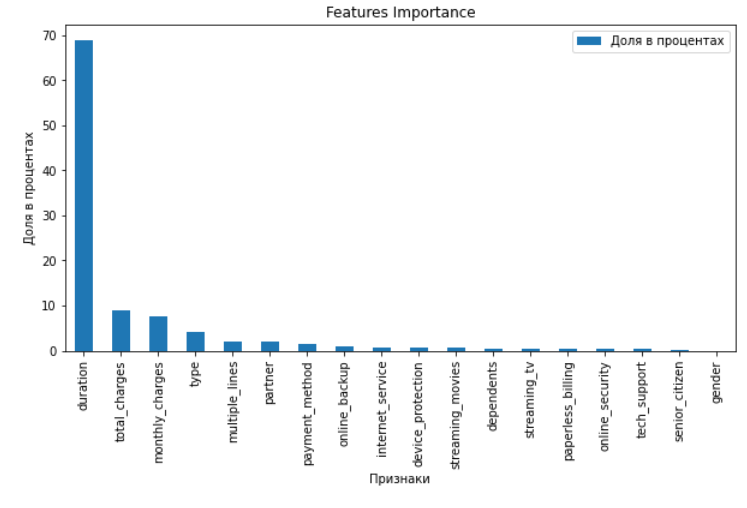

Наиболее важный параметр при предсказании - длительность пользования услугами, чуть менее важные параметры - месячный и суммарный платежи.